In [1]:
import os
import numpy as np
import faiss
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import pandas as pd
print(pd.__version__)


import plotly.express as px
from torchvision import datasets

2.2.3


In [2]:

def get_data_folder_path():
    data_folder = 'data'
    archive_file = 'dataArchive.zip'
    
    if not os.path.exists(data_folder):
        if os.path.exists(archive_file):
            with zipfile.ZipFile(archive_file, 'r') as zip_ref:
                zip_ref.extractall(data_folder)
        else:
            raise FileNotFoundError(f"'{archive_file}' does not exist.")
    return os.path.abspath(data_folder)


In [3]:
# Configuration
EMBEDDINGS_FILE = 'embeddings.npy'
LABELS_FILE = 'labels.npy'
INDEX_FILE = 'geology_index.faiss'
# MODEL_FILE = 'model.pth'
DATA_PATH = get_data_folder_path()


In [4]:
embeddings = np.load(EMBEDDINGS_FILE)
labels = np.load(LABELS_FILE)

print("Embeddings shape:", embeddings.shape)
print("Labels shape:", labels.shape)


Embeddings shape: (29998, 128)
Labels shape: (29998,)


In [5]:
index = faiss.read_index(INDEX_FILE)
print(f"Number of vectors in the index: {index.ntotal}")

Number of vectors in the index: 29998


In [6]:
dataset = datasets.ImageFolder(root=DATA_PATH, transform=None)
print("Number of images in dataset:", len(dataset))

Number of images in dataset: 29998


In [7]:
def retrieve_images(indices, dataset):
    image_paths = [dataset.samples[i][0] for i in indices[0]]
    images = [Image.open(path) for path in image_paths]
    return images

def show_images(base_img, similar_images):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, len(similar_images) + 1, 1)
    plt.imshow(base_img)
    plt.title('Base Image')
    plt.axis('off')
    for i, img in enumerate(similar_images):
        plt.subplot(1, len(similar_images) + 1, i + 2)
        plt.imshow(img)
        plt.title(f'Similar {i+1}')
        plt.axis('off')
    plt.show()

Query Index: 9949
Found neighbor indices: [[9949 7569 7471 7384 6524 6597]]
Distances: [[0.         0.00140413 0.00165415 0.00168003 0.00174268 0.00178017]]


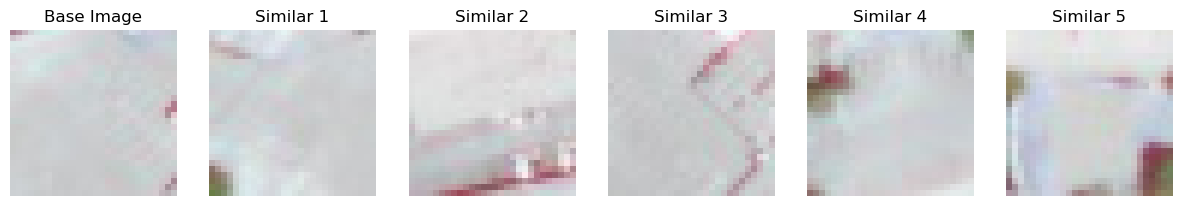

In [68]:
# Let's pick an embedding from the array to query its neighbors.
random_index = np.random.randint(embeddings.shape[0])
query_embedding = embeddings[random_index:random_index+1].astype('float32')
# Search the FAISS index for nearest neighbors
k = 5
distances, neighbor_indices = index.search(query_embedding, k + 1)

print("Query Index:", random_index)
print("Found neighbor indices:", neighbor_indices)
print("Distances:", distances)
# Display the query image and its neighbors
query_image_path = dataset.samples[random_index][0]
query_image = Image.open(query_image_path)
neighbors = retrieve_images(neighbor_indices, dataset)
show_images(query_image, neighbors[1:])

In [49]:
# 3D Visualization with PCA 
pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(embeddings)

df = pd.DataFrame({
    'x': embeddings_3d[:, 0],
    'y': embeddings_3d[:, 1],
    'z': embeddings_3d[:, 2],
    'label': labels
})

fig = px.scatter_3d(df, x='x', y='y', z='z', color='label', title="3D Representation of Embeddings")
fig.show()

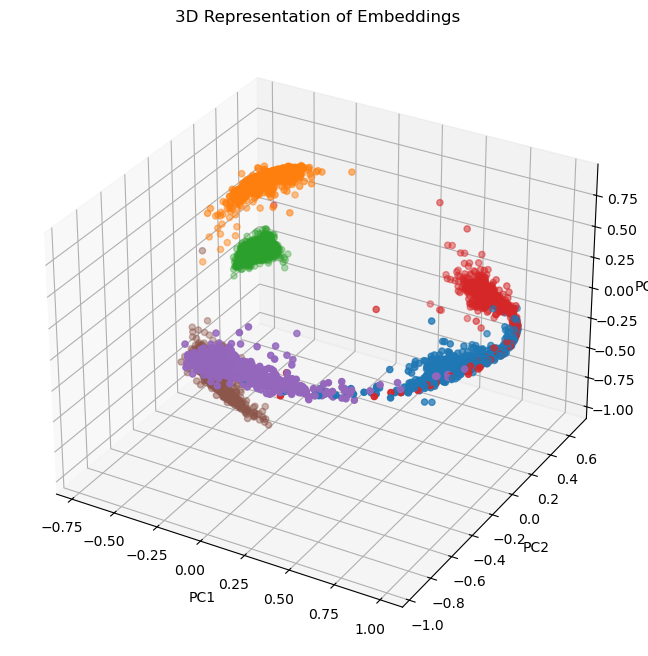

In [10]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
unique_labels = np.unique(labels)
color_map = plt.cm.tab10
colors = [color_map(int(l) % 10) for l in labels]
ax.scatter(embeddings_3d[:,0], embeddings_3d[:,1], embeddings_3d[:,2], c=colors, s=20)
ax.set_title("3D Representation of Embeddings")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()